In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score


import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip


--2025-05-29 08:04:25--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.207, 74.125.126.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/content/cassavaleafdata.zip’

/content/cassavalea 100%[===================>]   1.26G   188MB/s    in 6.4s    

2025-05-29 08:04:32 (201 MB/s) - ‘/content/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [5]:
!unzip /content/cassavaleafdata.zip

Archive:  /content/cassavaleafdata.zip
   creating: cassavaleafdata/
   creating: cassavaleafdata/test/
   creating: cassavaleafdata/test/cbb/
  inflating: cassavaleafdata/test/cbb/test-cbb-0.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-1.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-10.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-100.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-101.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-102.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-103.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-104.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-105.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-106.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-107.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-108.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-109.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-11.jpg  
  inflating: cassavaleafdata/test/cbb/test-cbb-110.jpg  
  inflat

In [6]:
data_paths = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test' : './cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

In [7]:
img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize ((150, 150)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
])

train_data = datasets.ImageFolder(
    root = data_paths['train'],
    loader = loader,
    transform = train_transforms
)

valid_data = datasets.ImageFolder(
    root = data_paths['valid'],
    transform = train_transforms
)

test_data = datasets.ImageFolder(
    root = data_paths['test'],
    transform = train_transforms
)

In [8]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

# Loop over the dataset to extract all images and labels
for img, label in train_data:
    X_train.append(img)        # img is already transformed (e.g., tensor)
    y_train.append(label)      # label is an int

# Stack into tensors
X_train = torch.stack(X_train)           # shape: [N, C, H, W]
y_train = torch.tensor(y_train)          # shape: [N]

for img, label in test_data:
    X_test.append(img)
    y_test.append(label)

X_test = torch.stack(X_test)
y_test = torch.tensor(y_test)

for img, label in valid_data:
    X_val.append(img)
    y_val.append(label)

X_val = torch.stack(X_val)
y_val = torch.tensor(y_val)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: torch.Size([5656, 3, 150, 150])
y_train shape: torch.Size([5656])
X_test shape: torch.Size([1885, 3, 150, 150])
y_test shape: torch.Size([1885])
X_val shape: torch.Size([1889, 3, 150, 150])
y_val shape: torch.Size([1889])


In [9]:
channel_means = X_train.float().mean(dim = (0, 2, 3))
channel_stds = X_train.float().std(dim = (0, 2, 3))
channel_means.shape, channel_stds.shape

(torch.Size([3]), torch.Size([3]))

In [10]:
class CustomDataset(data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def transforms(self, transforms):
        self.X = transforms(self.X)
        
        
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
val_data = CustomDataset(X_val, y_val)

In [11]:
train_transform = transforms.Compose([
    transforms.RandomCrop(150, padding = 2),
    transforms.RandomErasing(
        p = 0.75,
        scale = (0.01, 0.3),
        ratio = (1.0, 1.0),
        value = 0,
        inplace = True
    ),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Normalize(mean = channel_means.tolist(), std = channel_stds.tolist())
])

val_transform = transforms.Compose([
    transforms.Normalize(mean = channel_means.tolist(), std = channel_stds.tolist())
])

train_data.transforms(train_transform)
test_data.transforms(val_transform)
val_data.transforms(val_transform)

In [12]:
len(train_data), train_data[0][0].shape


(5656, torch.Size([3, 150, 150]))

In [13]:
batch = 32

train_loader = data.DataLoader(
    dataset = train_data,
    batch_size = batch,
    shuffle = True
)

test_loader = data.DataLoader(
    dataset = test_data,
    batch_size = batch,
    shuffle = False
)

val_loader = data.DataLoader(
    dataset = val_data,
    batch_size = batch,
    shuffle = False
)

# Preprocessing

In [14]:
next(iter(train_loader))[0].shape
# batch: 256
# channels: 3 (RGB)
# w x h : 150 x 150

torch.Size([32, 3, 150, 150])

In [15]:
len(next(iter(train_loader))[1].unique())

5

# Build Model

In [16]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=5):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.1),
            )

        self.feature_extractor = nn.Sequential(
            conv_block(in_channels, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            

            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            

            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            

            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*9*9, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        generator = torch.Generator().manual_seed(42)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=0.1, mode='fan_in', nonlinearity='leaky_relu', generator=generator)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=generator)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [17]:
in_channels = next(iter(train_loader))[0].shape[1]
num_classes = len(next(iter(train_loader))[1].unique())
model = CNN(in_channels = in_channels, num_classes = num_classes)
model

CNN(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1

In [18]:
import torch
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, (3, 150, 150))  # Input shape does NOT include batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
       BatchNorm2d-2         [-1, 64, 150, 150]             128
         LeakyReLU-3         [-1, 64, 150, 150]               0
            Conv2d-4         [-1, 64, 150, 150]          36,928
       BatchNorm2d-5         [-1, 64, 150, 150]             128
         LeakyReLU-6         [-1, 64, 150, 150]               0
            Conv2d-7         [-1, 64, 150, 150]          36,928
       BatchNorm2d-8         [-1, 64, 150, 150]             128
         LeakyReLU-9         [-1, 64, 150, 150]               0
        MaxPool2d-10           [-1, 64, 75, 75]               0
          Dropout-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,928
      BatchNorm2d-13           [-1, 64, 75, 75]             128
        LeakyReLU-14           [-1, 64,

# Set up Training Session

In [19]:
from typing import Literal, Optional
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler: callable = None, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None
        self.scheduler = scheduler

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for X_train, y_train in self.train_loader:
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)

            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train) # output: (batch_size, num_classes)

            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(torch.argmax(output, dim=1).tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect_val = ''
            score_collect_train = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

                score_collect_train += f'- {metric_name}: {metric_value}'

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect_val += f'- {metric_name}: {metric_value}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score}, saving model...") 
                        print("=====================")

            print(f'Epoch {epoch + 1} completed - Val Loss: {val_loss} ' + score_collect_val + f' - Train Loss: {train_loss} ' + score_collect_train) 
            
            if self.scheduler is not None:
                self.scheduler.step()
        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)

In [20]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR
epochs = 100
in_channels = next(iter(train_loader))[0].shape[1]
num_classes = len(next(iter(train_loader))[1].unique())
model = CNN(in_channels = in_channels, num_classes = num_classes)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01)
# Decay LR by gamma every step_size epochs
#scheduler = ExponentialLR(optimizer, gamma=0.9888)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.CrossEntropyLoss()

In [21]:
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    criterion = criterion,
    scheduler = scheduler,
    metrics = {"F1 Score": (f1_score, {"average" : "macro"})},
    refit = "F1 Score"
)
train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

Epoch 1: New best F1 Score on val = 0.2688269511457695, saving model...
Epoch 1 completed - Val Loss: 1.1311148923184267 - F1 Score: 0.2688269511457695 - Train Loss: 1.3499317894224736 - F1 Score: 0.2751781123501863
Epoch 2: New best F1 Score on val = 0.34761063886622795, saving model...
Epoch 2 completed - Val Loss: 1.06980766626563 - F1 Score: 0.34761063886622795 - Train Loss: 1.1283870486929866 - F1 Score: 0.31223575053592084
Epoch 3 completed - Val Loss: 1.0141788591715064 - F1 Score: 0.326087124979435 - Train Loss: 1.0859782589544165 - F1 Score: 0.3308243857799481
Epoch 4 completed - Val Loss: 1.2617512711650674 - F1 Score: 0.27393833093510633 - Train Loss: 1.044855990790916 - F1 Score: 0.33749943633416757
Epoch 5 completed - Val Loss: 0.9833519887267881 - F1 Score: 0.29645962035001194 - Train Loss: 1.042270819908153 - F1 Score: 0.3333560627048554
Epoch 6 completed - Val Loss: 0.9870103607107055 - F1 Score: 0.31994414666930227 - Train Loss: 1.0367659139835514 - F1 Score: 0.3316974

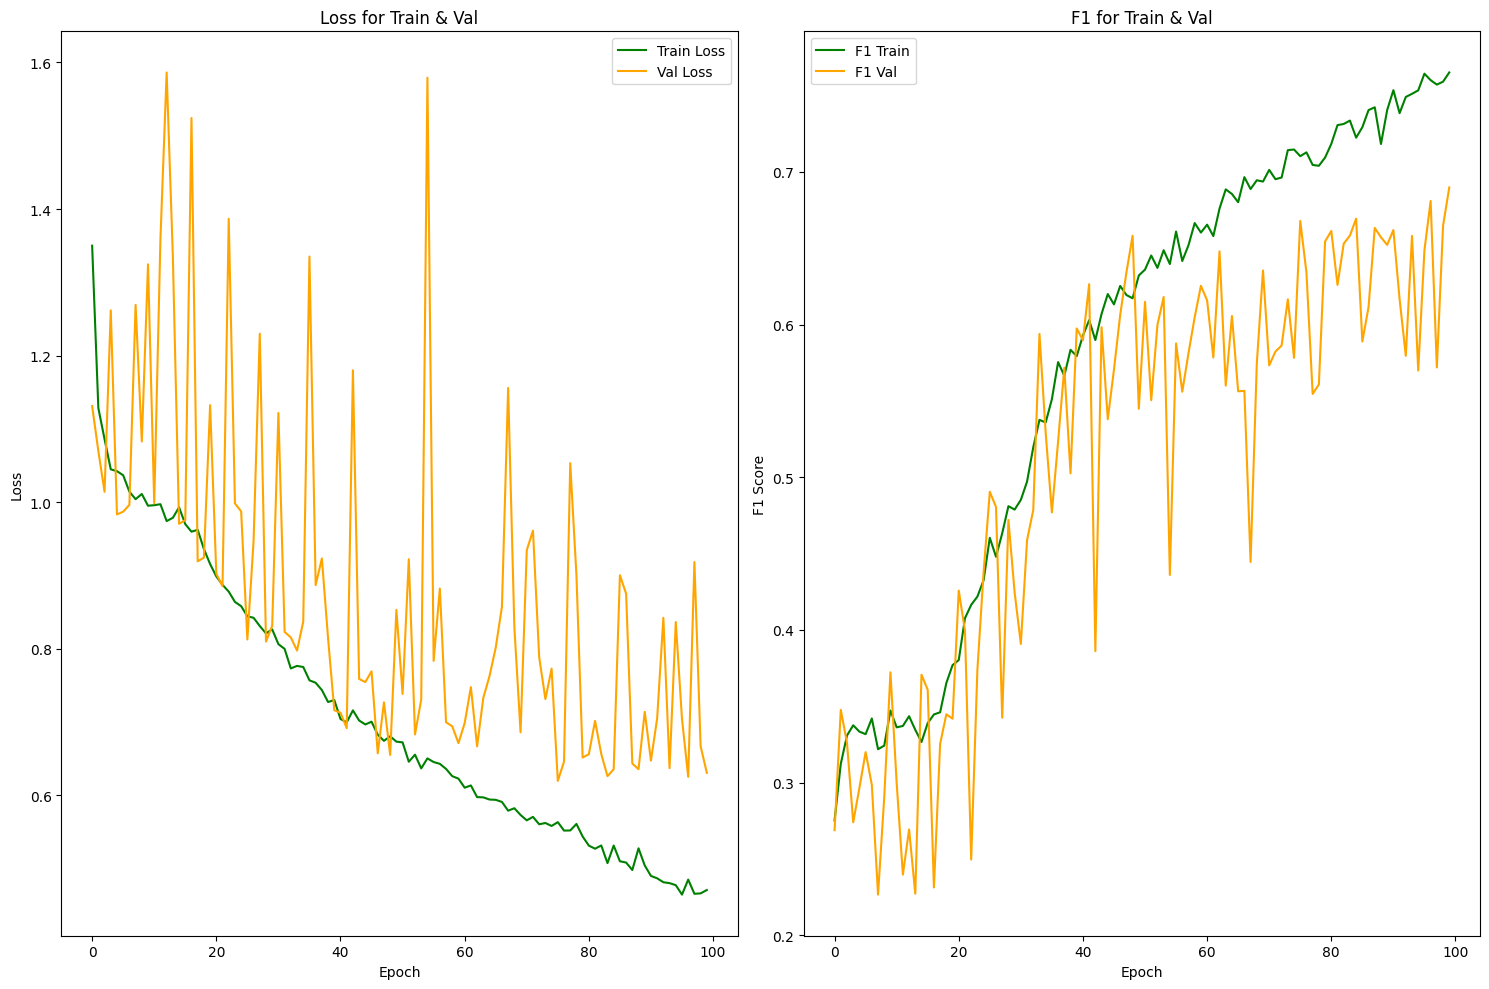

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(train_lossess, color='green', label = 'Train Loss')
ax[0].plot(val_lossess, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(metric_dict_train_collect['F1 Score'], color='green', label = 'F1 Train')
ax[1].plot(metric_dict_val_collect['F1 Score'], color='orange', label = 'F1 Val')
ax[1].set(xlabel='Epoch', ylabel='F1 Score')
ax[1].set_title('F1 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()

In [23]:
training.test()

Test session - Test Loss: 0.6228184401514676 - F1 Score: 0.6630911251031849
